<a href="https://colab.research.google.com/github/lvisdd/object_detection_tutorial/blob/master/keras_ssd_vgg16_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# restart (or reset) your virtual machine
#!kill -9 -1

# [Keras Implemention of CustomNetwork-SSD](https://github.com/tanakataiki/ssd_kerasV2)

## Mount Google Drive

In [1]:
# Mount Google Drive
# [Go to this URL in a browser: URL] -> Authorization Code
# [Enter your authorization code:]

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls -ld "/content/drive/My Drive/"

drwx------ 14 root root 4096 Sep 29 02:55 '/content/drive/My Drive/'


In [3]:
!git clone https://github.com/tanakataiki/ssd_kerasV2.git

Cloning into 'ssd_kerasV2'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 176 (delta 4), reused 21 (delta 2), pack-reused 153
Receiving objects: 100% (176/176), 50.99 MiB | 28.49 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [4]:
%cd ssd_kerasV2

/content/ssd_kerasV2


In [5]:
!perl -pi.bak -e "s|K.image_dim_ordering\(\) == 'tf'|K.image_data_format\(\) == 'channels_last'|g" /content/ssd_kerasV2/ssd_layers.py
!diff /content/ssd_kerasV2/ssd_layers.py.bak /content/ssd_kerasV2/ssd_layers.py

32c32
<         if K.image_dim_ordering() == 'tf':
---
>         if K.image_data_format() == 'channels_last':
84c84
<         if K.image_dim_ordering() == 'tf':
---
>         if K.image_data_format() == 'channels_last':


In [6]:
!perl -pi.bak -e "s|K.image_dim_ordering\(\) == 'tf'|K.image_data_format\(\) == 'channels_last'|g" /content/ssd_kerasV2/model/ssd300VGG16.py
!diff /content/ssd_kerasV2/model/ssd300VGG16.py.bak /content/ssd_kerasV2/model/ssd300VGG16.py

138c138
<     if K.image_dim_ordering() == 'tf':
---
>     if K.image_data_format() == 'channels_last':


In [7]:
%cd /content/ssd_kerasV2
%env PYTHONPATH=/env/python:/content/ssd_kerasV2:/content/ssd_kerasV2/model
%env

/content/ssd_kerasV2
env: PYTHONPATH=/env/python:/content/ssd_kerasV2:/content/ssd_kerasV2/model


{'CLICOLOR': '1',
 'CLOUDSDK_CONFIG': '/content/.config',
 'COLAB_GPU': '1',
 'CUDA_PKG_VERSION': '10-0=10.0.130-1',
 'CUDA_VERSION': '10.0.130',
 'CUDNN_VERSION': '7.6.3.30',
 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\\"172.28.0.2\\""]}',
 'DEBIAN_FRONTEND': 'noninteractive',
 'ENV': '/root/.bashrc',
 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16',
 'GIT_PAGER': 'cat',
 'GLIBCPP_FORCE_NEW': '1',
 'GLIBCXX_FORCE_NEW': '1',
 'HOME': '/root',
 'HOSTNAME': 'bcacafd76d5f',
 'JPY_PARENT_PID': '16',
 'LANG': 'en_US.UTF-8',
 'LAST_FORCED_REBUILD': '20190507',
 'LD_LIBRARY_PATH': '/usr/lib64-nvidia',
 'LD_PRELOAD': '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4',
 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs',
 'MPLBACKEND': 'module://ipykernel.pylab.backend_inline',
 'NCCL_VERSION': '2.4.8',
 'NO_GCE_CHECK': 'True',
 'NVIDIA_DRIVER_CAPABILITIES': 'compute,utility',
 'NVIDIA_REQUIRE_CUDA': 'cuda>=10.0 brand=tesla,driver>=384,dr

In [8]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
# from scipy.misc import imread
# from scipy.misc import imresize
from imageio import imread, imsave
from PIL import Image
import tensorflow as tf

from model.ssd300VGG16 import SSD
# from model.ssd300MobileNet import SSD
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))

Using TensorFlow backend.


In [0]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1

In [0]:
# some constants
# NUM_CLASSES = 4
# NUM_CLASSES = 21
input_shape = (300, 300, 3)

In [11]:
priors = pickle.load(open('priorFiles/prior_boxes_ssd300VGG16.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [12]:
%cd /content

/content


In [13]:
!git clone https://github.com/rykov8/ssd_keras.git

Cloning into 'ssd_keras'...
remote: Enumerating objects: 127, done.
remote: Total 127 (delta 0), reused 0 (delta 0), pack-reused 127
Receiving objects: 100% (127/127), 3.19 MiB | 7.75 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [14]:
%cd ssd_keras/PASCAL_VOC

/content/ssd_keras/PASCAL_VOC


In [15]:
!ls -l

total 4
-rw-r--r-- 1 root root 3279 Sep 29 02:56 get_data_from_XML.py


In [16]:
!wget https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
!wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!wget https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
!tar xf VOCtrainval_11-May-2012.tar
!tar xf VOCtrainval_06-Nov-2007.tar
!tar xf VOCtest_06-Nov-2007.tar

--2019-09-29 02:56:24--  https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/octet-stream]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  63.5MB/s    in 27s     

2019-09-29 02:56:51 (70.9 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]

--2019-09-29 02:56:52--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  71.3MB/s    in 6.6s    

2019-09-29 02:56:58 (66.7 MB

In [17]:
!ls -ld VOCdevkit/*

drwxrwxrwx 7 root root 4096 Nov  6  2007 VOCdevkit/VOC2007
drwxrwxrwx 7 root root 4096 May 11  2012 VOCdevkit/VOC2012


In [18]:
!perl -pi.bak -e "s|^# ||g;s|VOC2007/|VOCdevkit/VOC2007/|g;s|VOC2007.p|voc_2007.pkl|g" get_data_from_XML.py
!diff get_data_from_XML.py.bak get_data_from_XML.py

88,90c88,90
< # import pickle
< # data = XML_preprocessor('VOC2007/Annotations/').data
< # pickle.dump(data,open('VOC2007.p','wb'))
---
> import pickle
> data = XML_preprocessor('VOCdevkit/VOC2007/Annotations/').data
> pickle.dump(data,open('voc_2007.pkl','wb'))


In [0]:
!python get_data_from_XML.py

In [0]:
#!cp -p voc_2007.pkl /content/ssd_kerasV2

In [20]:
%cd /content/ssd_kerasV2

/content/ssd_kerasV2


In [0]:
gt = pickle.load(open('/content/ssd_keras/PASCAL_VOC/voc_2007.pkl', 'rb'))
keys = sorted(gt.keys())
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)

In [0]:
class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.]):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def generate(self, train=True):
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            for key in keys:            
                img_path = self.path_prefix + key
                # img = imread(img_path).astype('float32')
                img = imread(img_path)
                y = self.gt[key].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                # img = imresize(img, self.image_size).astype('float32')
                img = np.array(Image.fromarray(img).resize(self.image_size, resample=2))
                if train:
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    yield preprocess_input(tmp_inp), tmp_targets

In [0]:
# path_prefix = 'path2yourJPEG'
path_prefix = '/content/ssd_keras/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages/'
batch_size=16
gen = Generator(gt, bbox_util, batch_size, path_prefix,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

In [24]:
# model = SSD300(input_shape, num_classes=NUM_CLASSES)
model = SSD(input_shape, num_classes=NUM_CLASSES)

In [0]:
freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3']#,
#           'conv4_1', 'conv4_2', 'conv4_3', 'pool4']
# for L in model.layers:
#     if L.name in freeze:
#         L.trainable = False

In [0]:
!mkdir -p "/content/drive/My Drive/ssd_kerasV2/checkpoints"
!ln -s "/content/drive/My Drive/ssd_kerasV2/checkpoints" checkpoints

In [0]:
checkpoint_dir = './checkpoints'
# checkpoint_path = './checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint_path = './checkpoints/weights.hdf5'

import os
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

if os.path.isfile(checkpoint_path):
    model.load_weights(checkpoint_path)

In [0]:
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

In [29]:
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss,metrics=['acc'])


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


In [0]:
# nb_epoch = 30
# epochs = 30
epochs = 4
# batch_size=16
# history = model.fit_generator(gen.generate(True), gen.train_batches,
#                               nb_epoch, verbose=1,
#                               callbacks=callbacks,
#                               validation_data=gen.generate(False),
#                               nb_val_samples=gen.val_batches,
#                               nb_worker=1)
history = model.fit_generator(gen.generate(True), 
                              steps_per_epoch=gen.train_batches,
                              epochs=epochs, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              validation_steps=gen.val_batches,
                              workers=1)

Epoch 1/4
7970/7970 [==============================] - 9391s 1s/step - loss: 1.0076 - acc: 0.3842 - val_loss: 4.4702 - val_acc: 0.3925

Epoch 00001: val_loss improved from inf to 4.47023, saving model to ./checkpoints/weights.hdf5
Epoch 2/4
7970/7970 [==============================] - 9376s 1s/step - loss: 0.9104 - acc: 0.3985 - val_loss: 4.4157 - val_acc: 0.3937

Epoch 00002: val_loss improved from 4.47023 to 4.41571, saving model to ./checkpoints/weights.hdf5
Epoch 3/4
7970/7970 [==============================] - 9365s 1s/step - loss: 0.8944 - acc: 0.3995 - val_loss: 4.4201 - val_acc: 0.3939

Epoch 00003: val_loss did not improve from 4.41571
Epoch 4/4
7969/7970 [============================>.] - ETA: 1s - loss: 0.8950 - acc: 0.3994

In [0]:
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[0]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [31]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

1/1 [==============================] - 4s 4s/step


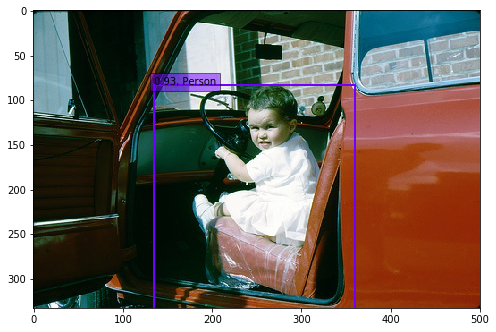

In [32]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    # colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()
    colors = plt.cm.hsv(np.linspace(0, 1, NUM_CLASSES)).tolist()
    
    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        # display_txt = '{:0.2f}, {}'.format(score, label)
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()